<a href="https://colab.research.google.com/github/aszmul/X-ray-Cone-Beam-Computed-Tomography/blob/master/cyclegan_2D_phantom_multitask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



cycleGAN CT-CBCT PHANTOM
==============


Introduction
------------
cycle Generative Adversarial Networks
-------------------------------

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torchvision
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import pickle
from monai.transforms import (
    Compose,
    GaussianSmoothd,
    AddChanneld,
    RandRotated,
    RandFlipd,
    RandBiasFieldd,
    RandGaussianNoised,
    ThresholdIntensityd,
    RandGibbsNoised,
    Resized,
    CenterSpatialCropd,
    ToTensord,
    ScaleIntensityd,
    NormalizeIntensityd,
    AsChannelFirstd
)
from monai.losses import DiceLoss, DiceCELoss

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [ ]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/Colab Notebooks/phantom_data/phantom_ct/"

workers = 4 # Number of workers for dataloader
batch_size = 64 # Batch size during training

kernel_size=(7, 7)
first_image_size = 64

image_size = 128 # Spatial size of training images. All images will be resized to this size using a transformer.
nc = 1 # Number of channels in the training images. For color images this is 3

nz = 100# Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator

ndf = 64 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs


lr = 0.0002 # Learning rate for optimizers

beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

Data
----
We will be using data synthetic phantom data with corresponding segmentations

['ct_combined_12.pickle', 'ct_combined_11.pickle', 'ct_combined_3.pickle', 'ct_combined_0.pickle', 'ct_combined_5.pickle', 'ct_combined_6.pickle', 'ct_combined_14.pickle', 'ct_combined_7.pickle', 'ct_combined_9.pickle', 'ct_combined_13.pickle', 'ct_combined_2.pickle', 'ct_combined_4.pickle', 'ct_combined_8.pickle', 'ct_combined_10.pickle', 'ct_combined_1.pickle', 'ct_combined_22.pickle', 'ct_combined_16.pickle', 'ct_combined_17.pickle', 'ct_combined_28.pickle', 'ct_combined_19.pickle', 'ct_combined_33.pickle', 'ct_combined_24.pickle', 'ct_combined_31.pickle', 'ct_combined_15.pickle', 'ct_combined_34.pickle', 'ct_combined_29.pickle', 'ct_combined_20.pickle', 'ct_combined_21.pickle', 'ct_combined_35.pickle', 'ct_combined_18.pickle', 'ct_combined_32.pickle', 'ct_combined_36.pickle', 'ct_combined_23.pickle', 'ct_combined_26.pickle', 'ct_combined_30.pickle', 'ct_combined_27.pickle', 'ct_combined_25.pickle', 'ct_combined_46.pickle', 'ct_combined_50.pickle', 'ct_combined_37.pickle', 'ct_combi

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(64, 1, 128, 128)


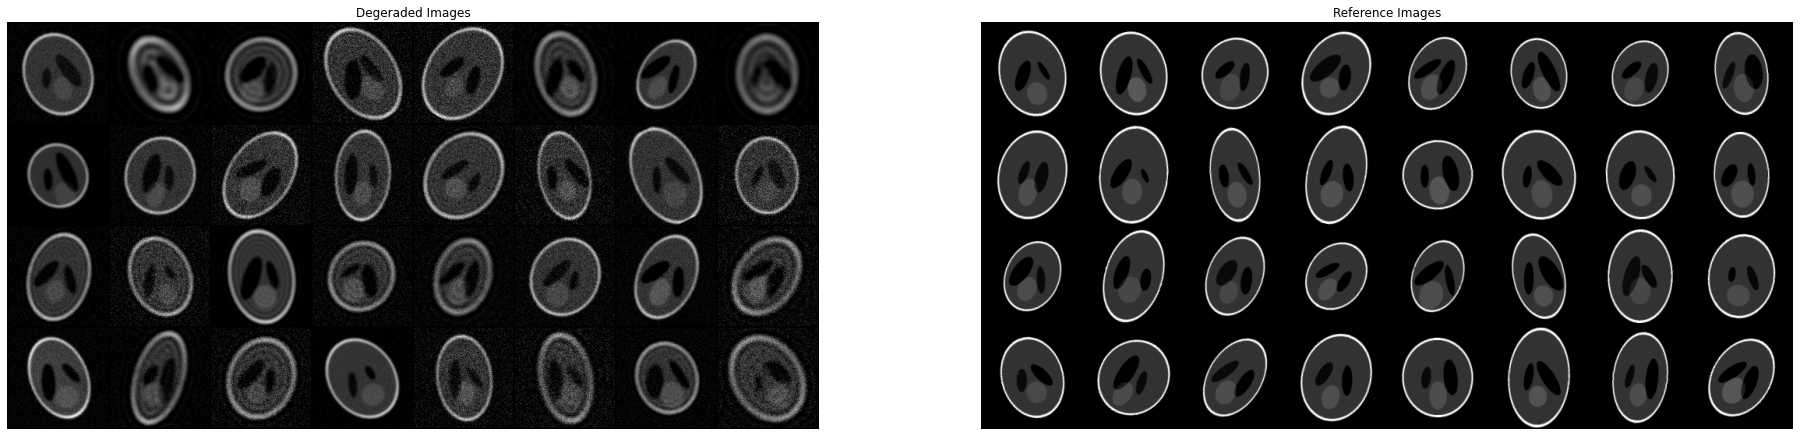

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

# Custom dataload for loading images and labels
class PhantomSegsDataset(Dataset):
    """Phantom CT and segmentations dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
                    -- [phantom_combined_XXX]            files with images and segmentations as dir in pickle format
                        {'image', 'seg'}
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        temp_list = os.listdir(root_dir)
        # print(temp_list)

        self.files_list = []

        # limit the list of files for trainging to 4000
        for file_name in temp_list:
          if int(file_name.split('.pickle')[0].split('combined_')[1]) < 200:
            self.files_list.append(file_name)


        # print(temp_list)
        self.files_list = temp_list.copy()
        self.root_dir = root_dir
        self.transform = transform
        # print(self.files_list)

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_name = self.files_list[idx]
        # load as numpy and scale intensity 0-1

        data_file = open(self.root_dir + sample_name, 'rb')
        data = pickle.load(data_file)
        data_file.close()
        image = data['image']
        seg = data['seg']

        # image = np.asarray(Image.open(self.root_dir  + 'real/' + img_name))/255

        # seg_name = self.image_list[idx].split('.jpg')[0] + '_comb.npy'
        # seg = np.load(self.root_dir + 'labels_combined/' + seg_name)

        sample = {'image': image, 'seg': seg}

        if self.transform:
            sample = self.transform(sample)

        return sample


CBCT_transforms=Compose([
                               AddChanneld(keys=['image', 'seg']),
                               GaussianSmoothd(keys=['image'], sigma= 2.0),
                               Resized(keys=['image'], spatial_size = (first_image_size, first_image_size), mode="nearest"),
                               Resized(keys=['image', 'seg'], spatial_size = (image_size, image_size), mode=("bilinear", "nearest")),
                               CenterSpatialCropd(keys=['image', 'seg'], roi_size = (image_size, image_size)),
                               RandFlipd(keys=['image', 'seg'], prob=0.5, spatial_axis=1),
                               RandRotated(keys=['image', 'seg'], range_x=[-0.6, 0.6], prob=1, mode=['bilinear', 'nearest'], padding_mode='zeros'),
                               RandBiasFieldd(keys=['image'], degree=3, coeff_range=(0.0, 0.3), prob=0.1), 
                               RandGibbsNoised(keys=['image'], prob=1.0, alpha=(0.5, 0.9), as_tensor_output=False),
                               RandGaussianNoised(keys=['image'], prob=1.0, mean=0.0, std=0.1),
                               ThresholdIntensityd(keys=['image'], threshold=1.0, above=False, cval=1.0),
                               ThresholdIntensityd(keys=['image'], threshold=0.0, above=True, cval=0.0),
                               ToTensord(keys=['image', 'seg']),
                               NormalizeIntensityd(keys=['image'], subtrahend = 0.5, divisor = 0.5),
                           ])


CT_transforms=Compose([
                               AddChanneld(keys=['image', 'seg']),
                               Resized(keys=['image', 'seg'], spatial_size = (image_size, image_size), mode=("bilinear", "nearest")),
                               CenterSpatialCropd(keys=['image', 'seg'], roi_size = (image_size, image_size)),
                               RandFlipd(keys=['image', 'seg'], prob=0.5, spatial_axis=1),
                               RandRotated(keys=['image', 'seg'], range_x=[-0.6, 0.6], prob=1, mode=['bilinear', 'nearest'], padding_mode='zeros'),
                               ThresholdIntensityd(keys=['image'], threshold=1.0, above=False, cval=1.0),
                               ThresholdIntensityd(keys=['image'], threshold=0.0, above=True, cval=0.0),
                               ToTensord(keys=['image', 'seg']),
                               NormalizeIntensityd(keys=['image'], subtrahend = 0.5, divisor = 0.5),
                           ])


CBCT_dataset = PhantomSegsDataset(root_dir=dataroot, transform=CBCT_transforms)

CT_dataset = PhantomSegsDataset(root_dir=dataroot, transform=CT_transforms)


# Create the dataloader
CBCT_dataloader = torch.utils.data.DataLoader(CBCT_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

CT_dataloader = torch.utils.data.DataLoader(CT_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
CBCT_batch = next(iter(CBCT_dataloader))
CT_batch = next(iter(CT_dataloader))
plt.figure(figsize=(32,32))


print(CBCT_batch['image'].shape)

plt.subplot(1,2,1)
plt.axis("off")
plt.title("CBCT Images")
plt.imshow(np.transpose(vutils.make_grid(CBCT_batch['image'].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("CT Images")
plt.imshow(np.transpose(vutils.make_grid(CT_batch['image'].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

(64, 1, 128, 128)


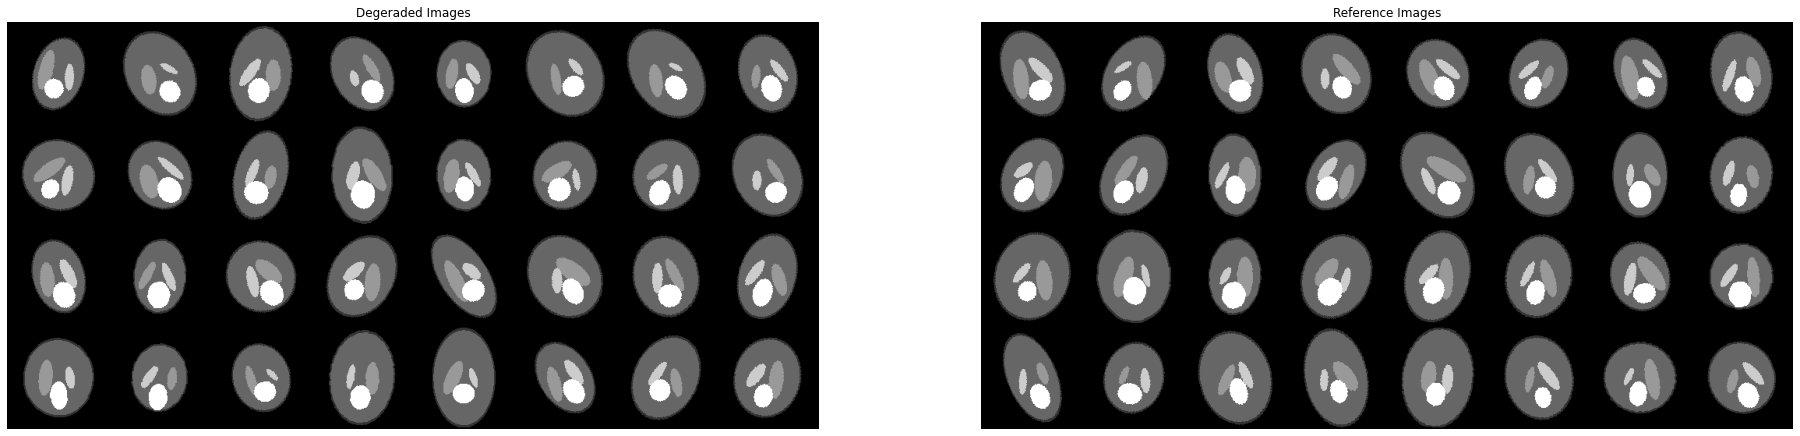

In [ ]:
# Plot some training images
CBCT_batch = next(iter(CBCT_dataloader))
CT_batch = next(iter(CT_dataloader))
plt.figure(figsize=(32,32))


print(CBCT_batch['image'].shape)


plt.subplot(1,2,1)
plt.axis("off")
plt.title("CBCT Labels")
plt.imshow(np.transpose(vutils.make_grid(CBCT_batch['seg'].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("CT Labels")
plt.imshow(np.transpose(vutils.make_grid(CT_batch['seg'].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
CBCT_batch = next(iter(CBCT_dataloader))

CBCT_batch['image'].size()

(64, 1, 128, 128)

Implementation
--------------

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

Weight Initialization
~~~~~~~~~~~~~~~~~~~~~

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.




In [ ]:
# custom weights initialization called on netG and netD
# not included yet
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator
~~~~~~~~~



In [ ]:
# Generator Code
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)        


class Encoder(nn.Module):
  def __init__(self, n_channels=1, bilinear=False):
      super(Encoder, self).__init__()
      self.n_channels = n_channels
      self.bilinear = bilinear

      self.inc = DoubleConv(self.n_channels, 16)
      self.down1 = Down(16, 32)
      self.down2 = Down(32, 64)
      self.down3 = Down(64, 128)

  def forward(self, x):
      x1 = self.inc(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      return x1, x2, x3, x4

class Decoder(nn.Module):
  def __init__(self, n_classes, bilinear=False):
      super(Decoder, self).__init__()
      self.n_classes = n_classes
      self.bilinear = bilinear

      factor = 2 if bilinear else 1
      self.up1 = Up(128, 64 // factor, bilinear)
      self.up2 = Up(64, 32 // factor, bilinear)
      self.up3 = Up(32, 16, bilinear)
      self.outc = OutConv(16, n_classes)

  def forward(self, x1, x2, x3, x4):
      x = self.up1(x4, x3)
      x = self.up2(x, x2)
      x = self.up3(x, x1)
      refined = self.outc(x)
      return refined

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [ ]:
# Create the generator for synCT images and segmentations
net_CT_G_E = Encoder(n_channels=1).to(device)
net_CT_G_D_img = Decoder(n_classes=1).to(device)
net_CT_G_D_seg = Decoder(n_classes=9).to(device)

# Create the generator for synCBCT images only
net_CBCT_G_E = Encoder(n_channels=1).to(device)
net_CBCT_G_D_img = Decoder(n_classes=1).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    net_CT_G_E = nn.DataParallel(net_CT_G_E, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CT_G_D_img = nn.DataParallel(net_CT_G_D_img, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CT_G_D_seg = nn.DataParallel(net_CT_G_D_seg, list(range(ngpu)))    

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_G_E = nn.DataParallel(net_CBCT_G_E, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_G_D_img = nn.DataParallel(net_CBCT_G_D_img, list(range(ngpu)))


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
# netG.apply(weights_init)

# Print the model
# print(netG_E)
# print(netG_D_img)
# print(netG_D_seg)

Discriminator
~~~~~~~~~~~~~



Discriminator Code



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input is (nc) x 64 x 64
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [ ]:
# Create the Discriminator for synCT images 
net_CT_D_img = Discriminator(ngpu).to(device)

# Create the Discriminator for synCT segmentations
net_CBCT_D_seg = Discriminator(ngpu).to(device)

# Create the Discriminator for synCBCT images 
net_CBCT_D_img = Discriminator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    net_CT_D_img = nn.DataParallel(net_CT_D_img, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_D_img = nn.DataParallel(net_CBCT_D_img, list(range(ngpu)))

if (device.type == 'cuda') and (ngpu > 1):
    net_CBCT_D_seg = nn.DataParallel(net_CBCT_D_seg, list(range(ngpu)))    
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
net_CT_D_img.apply(weights_init)
net_CBCT_D_img.apply(weights_init)
net_CBCT_D_seg.apply(weights_init)


# Print the model
print(net_CBCT_D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, 

Loss Functions and Optimizers
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()
# criterion_degraded = nn.MSELoss()
criterion_degraded = DiceCELoss(include_background=True, to_onehot_y=True, softmax=True, lambda_dice=0.5, lambda_ce=0.5)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D for CT arm
optimizer_CT_D_img = optim.Adam(net_CT_D_img.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_CT_G_E = optim.Adam(net_CT_G_E.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_CT_G_D_img = optim.Adam(net_CT_G_D_img.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_CT_G_D_seg = optim.Adam(net_CT_G_D_seg.parameters(), lr=lr, betas=(beta1, 0.999))

# Setup Adam optimizers for both G and D for CBCT arm
optimizer_CBCT_D_img = optim.Adam(net_CBCT_D_img.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_CBCT_D_seg = optim.Adam(net_CBCT_D_seg.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_CBCT_G_E = optim.Adam(net_CBCT_G_E.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_CBCT_G_D_img = optim.Adam(net_CBCT_G_D_img.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_CBCT_G_D_seg = optim.Adam(net_CT_G_D_seg.parameters(), lr=lr, betas=(beta1, 0.999))

Training
~~~~~~~~

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




In [ ]:
# Training Loop

# Lists to keep track of progress
before_list = []
after_list = []
seg_list = []
seg_ref_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch

num_epochs = 200

for epoch in range(num_epochs):
    # For each batch in the dataloader
    # for i, data in enumerate(dataloader, 0):
    i = 0
    # for degraded_item, reference_item in zip(degraded_dataloader, reference_dataloader):

    #     degraded_batch, degraded_labels = degraded_item
    #     reference_batch, reference_labels = reference_item
    for i, (degraded_batch, reference_batch) in enumerate(zip(degraded_dataloader, reference_dataloader)):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = reference_batch['image'].to(device)
        b_size = real_cpu.size(0)
        reference_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # print(netD(real_cpu).shape)

        # Calculate loss on all-real batch

        # print(output.shape)
        # print(reference_label.shape)
        errD_real = criterion(output, reference_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch

        # Generate refined image batch with G

        # print('Degarade batch:', degraded_batch)
        x1, x2, x3, x4 = netG_E(degraded_batch['image'].to(device))
        fake_img = netG_D_img(x1, x2, x3, x4)
        fake_seg = netG_D_seg(x1, x2, x3, x4).double()
        
        # Classify all fake batch with D
        output = netD(fake_img.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        degraded_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        errD_fake = criterion(output, degraded_label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_E.zero_grad()
        netG_D_img.zero_grad()
        netG_D_seg.zero_grad()
        degraded_label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake_img).view(-1)
        # Calculate G's loss based on this output
        degraded_ref_seg = degraded_batch['seg'].to(device)

        errG = criterion(output, degraded_label) + criterion_degraded(fake_seg, degraded_ref_seg)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_E.step()
        optimizerG_D_img.step()
        optimizerG_D_seg.step()

        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(degraded_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 200 == 0) or ((epoch == num_epochs-1) and (i == len(degraded_dataloader)-1)):
            with torch.no_grad():
                x1, x2, x3, x4 = netG_E(degraded_batch['image'].to(device))
                fake_img = netG_D_img(x1, x2, x3, x4).detach().cpu()
                fake_seg = torch.argmax(netG_D_seg(x1, x2, x3, x4), dim=1, keepdim=True).detach().cpu()
                # print('fake_img', fake_img.size())
                # print('fake_seg_before', (netG_D_seg(x1, x2, x3, x4).detach().cpu()).size())
                # print('fake_seg', fake_seg.size())

                # plt.hist(degraded_batch['seg'].numpy().flatten(), 20)
                # plt.show()

                # plt.hist(fake_seg.numpy().flatten(), 20)
                # plt.show()



            before_list.append(vutils.make_grid(degraded_batch['image'], padding=2, normalize=True))    
            after_list.append(vutils.make_grid(fake_img, padding=2, normalize=True))

            seg_ref_list.append(vutils.make_grid(degraded_batch['seg'], padding=2, normalize=False))    
            seg_list.append(vutils.make_grid(fake_seg, padding=2, normalize=False))
            
        iters += 1
        i += 1


Starting Training Loop...
[0/200][0/4]	Loss_D: 0.4359	Loss_G: 6.7039	D(x): 0.9959	D(G(z)): 0.3049 / 0.0117
[1/200][0/4]	Loss_D: 1.4954	Loss_G: 3.2321	D(x): 0.3249	D(G(z)): 0.0004 / 0.2597
[2/200][0/4]	Loss_D: 1.5326	Loss_G: 10.6111	D(x): 0.9955	D(G(z)): 0.6947 / 0.0004
[3/200][0/4]	Loss_D: 0.8243	Loss_G: 2.8731	D(x): 0.5088	D(G(z)): 0.0034 / 0.2722
[4/200][0/4]	Loss_D: 0.6605	Loss_G: 4.7199	D(x): 0.9944	D(G(z)): 0.4030 / 0.0393
[5/200][0/4]	Loss_D: 0.3575	Loss_G: 5.8361	D(x): 0.9894	D(G(z)): 0.2562 / 0.0158
[6/200][0/4]	Loss_D: 0.2444	Loss_G: 4.2221	D(x): 0.8137	D(G(z)): 0.0147 / 0.0687
[7/200][0/4]	Loss_D: 0.1113	Loss_G: 3.6689	D(x): 0.9374	D(G(z)): 0.0411 / 0.0895
[8/200][0/4]	Loss_D: 0.1529	Loss_G: 2.8910	D(x): 0.8903	D(G(z)): 0.0295 / 0.1860
[9/200][0/4]	Loss_D: 3.5863	Loss_G: 12.8223	D(x): 0.9992	D(G(z)): 0.9040 / 0.0001
[10/200][0/4]	Loss_D: 0.5624	Loss_G: 3.2185	D(x): 0.7665	D(G(z)): 0.1660 / 0.1607
[11/200][0/4]	Loss_D: 0.5610	Loss_G: 2.4040	D(x): 0.6536	D(G(z)): 0.0230 / 0.291

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




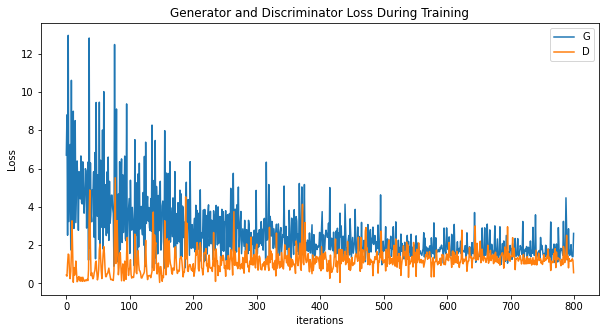

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




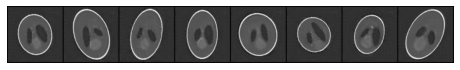

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in after_list]
# ims = [[plt.imshow(np.transpose(i,(1,2,0))[:,:,0], animated=True)] for i in seg_ref_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




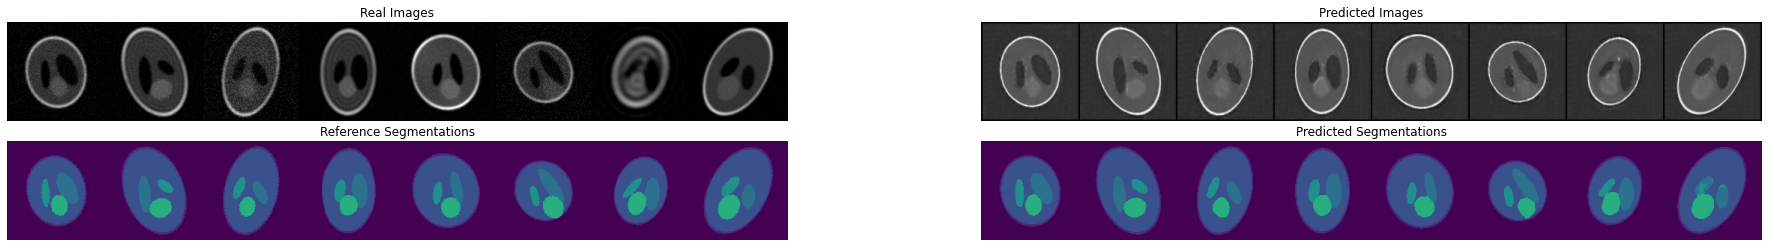

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(reference_dataloader))

# Plot the real images
plt.figure(figsize=(32,4))


plt.subplot(2,2,1)
plt.axis("off")
plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# plt.title("Degraded Images")
plt.imshow(np.transpose(before_list[-1],(1,2,0)))

# print(before_list[0])

# Plot the degraded images from the last epoch
plt.subplot(2,2,2)
plt.axis("off")
# plt.title("Degraded Images")
plt.imshow(np.transpose(after_list[-1],(1,2,0)))
plt.title("Predicted Images")


# Plot the refined images from the last epoch
plt.subplot(2,2,3)
plt.axis("off")
plt.title("Reference Segmentations")
# plt.imshow(np.transpose(after_list[-2],(1,2,0)))
plt.imshow(np.transpose(seg_ref_list[-1],(1,2,0))[:,:,0], vmin=0, vmax=8)

# print(after_list[0])

plt.subplot(2,2,4)
plt.axis("off")
# plt.title("Degraded Images")
# plt.imshow(np.transpose(before_list[-1],(1,2,0)))
plt.title("Predicted Segmentations")
plt.imshow(np.transpose(seg_list[-1],(1,2,0)).astype(float)[:,:,0], vmin=0, vmax=8)
plt.show()

# print(seg_ref_list[0])
# print(seg_list[0])


tensor(1.)
Metadata
	affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)

Applied operations
[]
Is batch?: False
(132, 1042, 3)
float64
float64


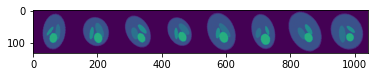

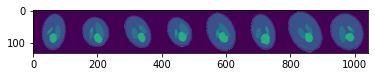

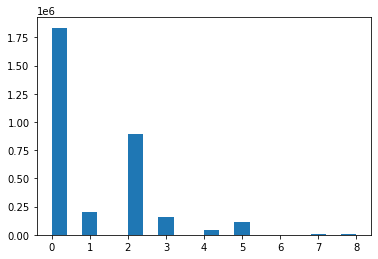

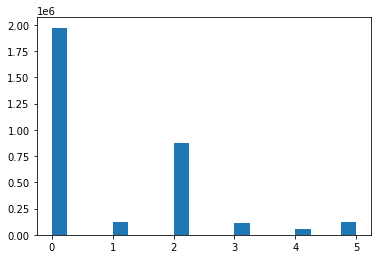

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [ ]:
seg_ref_im = np.transpose(seg_ref_list[-1].numpy(),(1,2,0)).astype(float)

# print(seg_ref_im.min())
# print(seg_ref_im.max())


seg_im = np.transpose(seg_list[-1].numpy(),(1,2,0)).astype(float)

print(after_list[0].max())
print(seg_im.shape)

print(seg_ref_im.dtype)
print(seg_im.dtype)

plt.imshow(seg_ref_im[:,:,0], vmin=0, vmax=8)
plt.show()

plt.imshow(seg_im[:,:,0], vmin=0, vmax=8)
plt.show()


plt.hist(seg_list[-2].numpy().flatten(),20)
plt.show()

plt.hist(seg_ref_list[-2].numpy().flatten(),20)
plt.show()

print(seg_im)